In [254]:
from scipy.stats import norm
import numpy as np
import sympy
import scipy
import torch
from numpy import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm

In [255]:
# Simulate the input X
def sim_geno(n,m,p): # checked!
    X = random.binomial(2, p, size=[n,m]) / np.sqrt(n)
    # for debugging purposes we simulate a Gaussian matrix and scale it 
    #X = random.normal(loc=0.0, scale=1.0, size=[n,m]) / np.sqrt(n)
    return X

# Simulate the coefficients beta
def sim_beta(m, la, sigma): # checked!
    beta = random.normal(loc=0.0, scale=np.sqrt(sigma), size=[m,1]) # scale = standard deviation
    beta *= random.binomial(1, la, size=[m,1])
    return beta

def mathematica_evd(n, loc, scale):
    wi = np.random.gumbel(loc=loc, scale=scale, size=[n, 1])
    return wi

# Simulate the outcomes Y
def sim_pheno(X, beta, mu, h2):
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    varwi = np.pi * np.pi / 6
    c = np.sqrt((1/h2-1) * sigmaG / varwi)
    
    wi = -mathematica_evd(n=n, loc=-0, scale=1.0)
    # wi = -np.random.gumbel(loc=0, scale=1.0, size=[n, 1])

    y = np.exp(mu + g + c * (wi + emc) )
    # An equivalent formulation would be: 
    # y = np.exp(-mathematica_evd(n=n, loc = -(mu+g+c*emc), scale=c))
    alpha = 1.0 / c
    return y, alpha

def sim_model(n,m,p,la,sigma,h2):
    X = sim_geno(n,m,p)
    beta = sim_beta(m, la, sigma)
    mu = np.zeros((n,1))
    y, alpha = sim_pheno(X, beta, mu, h2)
    return X,beta,y,alpha

In [346]:
n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
h2=0.5
mu=0
    
X,beta,y,alpha = sim_model(n,m,p,la,sigma,h2)
alpha

3.091658450477903

In [428]:
n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
h2=0.5
    
X,beta,y,alpha = sim_model(n,m,p,la,sigma,h2)
alpha

3.074546236251838

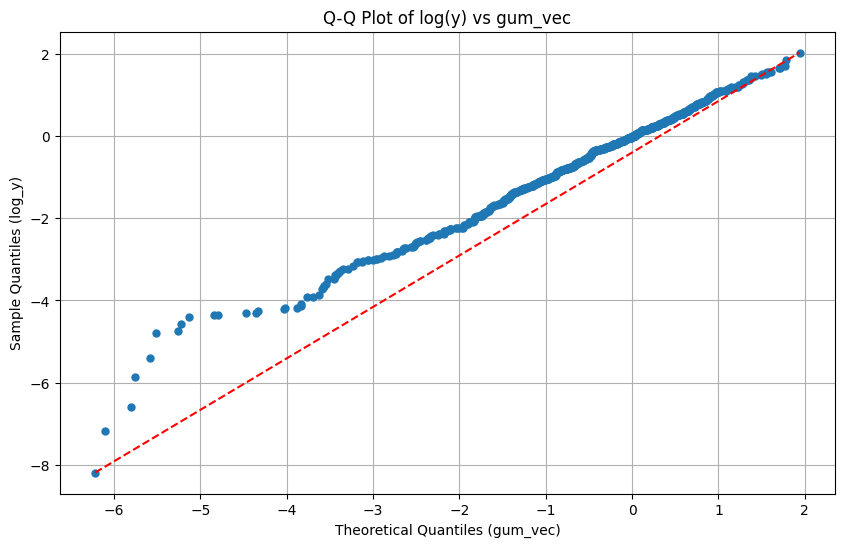

In [430]:
# Sort the vectors
log_y = alpha * (np.log(y) - X@beta - np.zeros((n,1)) - emc / alpha)
gum_vec = -mathematica_evd(n=n, loc=-0, scale=1.0)
sorted_gum_vec = np.sort(gum_vec.flatten())
sorted_log_y = np.sort(log_y.flatten())

# Create Q-Q plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_gum_vec, sorted_log_y, 'o', markersize=5)
plt.plot([min(sorted_gum_vec), max(sorted_gum_vec)], [min(sorted_log_y), max(sorted_log_y)], 'r--')

# Add title and labels
plt.title('Q-Q Plot of log(y) vs gum_vec')
plt.xlabel('Theoretical Quantiles (gum_vec)')
plt.ylabel('Sample Quantiles (log_y)')

# Show plot
plt.grid(True)
plt.show()

Corrected Weibull likelihood is given by

$$
-\mathrm{e}^{-a{\mu} - az_{hat} - K} \left(Y^{a} \mathrm{e}^{\frac{a^{2}}{2{\xi}}} + \left(a\mathrm{e}^{az_{hat} + K} {\mu} + \left(\mathrm{e}^{K} az_{hat} - \mathrm{e}^{K} \ln\left(a\right) - \mathrm{e}^{K} \ln\left(Y\right) \, a + K\mathrm{e}^{K}\right) \mathrm{e}^{az_{hat}}\right) \mathrm{e}^{a{\mu}}\right)
$$

In [431]:
# Define the Weibull likelihood function in PyTorch
def weibull_log_likelihood_belief(z_hat, Y, a, mu, xi, K):
    term1 = torch.exp(-a * mu - a * z_hat - K)
    term2 = Y ** a * torch.exp(a ** 2 / (2 * xi))
    term3 = a * torch.exp(a * z_hat + K) * mu
    # added a new term: - torch.exp(K) * torch.log(a)
    term4 = (torch.exp(K) * a * z_hat - torch.exp(K) * torch.log(a) - torch.exp(K) * torch.log(Y) * a + K * torch.exp(K)) * torch.exp(a * z_hat)
    term5 = torch.exp(a * mu)

    result = -term1 * (term2 + (term3 + term4) * term5)
    return torch.sum(result)
weibull_log_likelihood_belief(
    torch.tensor(X@beta), 
    torch.tensor(y), 
    torch.tensor(alpha), 
    torch.tensor(mu),
    torch.tensor(15), 
    torch.tensor(emc)
)

tensor(-664.5998, dtype=torch.float64)

In [ ]:
def weibull_log_likelihood(X, beta, y, mu, alpha):
    K = torch.tensor(emc)
    X=torch.tensor(X)
    beta=torch.tensor(beta)
    y=torch.tensor(y) 
    mu=torch.tensor(mu)
    alpha=torch.tensor(alpha)
    z = X@beta
    c = alpha*(torch.log(y) - mu - z - K / alpha)
    return torch.sum(torch.log(alpha) + c - torch.exp(c)).item()
weibull_log_likelihood(X, beta, y, 0, 2.9)

This code finds the correct alpha and mu

In [432]:
def plot_likelihood(interval_s, interval_e, num_points, lik_func, var_type, lik_type, X, beta, y, alpha, mu=0, xi=15):
    # Generate 1000 values of mu from -100 to 100
    values = np.linspace(interval_s, interval_e, num_points)
    
    if var_type == "alpha":
            og_val = alpha
            if lik_type == "weibull_belief":
                neg_log_likelihood_values = [-lik_func(
                      torch.tensor(X@beta), 
                      torch.tensor(y), 
                      torch.tensor(a),
                      torch.tensor(mu),
                      torch.tensor(xi),
                      torch.tensor(emc),
                ) for a in values]
            else:
                neg_log_likelihood_values = [-lik_func(
                     X,
                     beta, 
                     y, 
                     mu, 
                     a) 
                for a in values]
            
    elif var_type == "mu":
            og_val = mu
            if lik_type == "weibull_belief":
                neg_log_likelihood_values = [-lik_func(
                      torch.tensor(X@beta), 
                      torch.tensor(y), 
                      torch.tensor(alpha),
                      torch.tensor(m),
                      torch.tensor(xi),
                      torch.tensor(emc),
                ) for m in values]
            else:
                neg_log_likelihood_values = [-lik_func(
                     X,
                     beta, 
                     y, 
                     m, 
                     alpha) 
                for m in values]
            
    min_index = np.argmin(neg_log_likelihood_values)
    min_val = values[min_index]

    print(f"The {var_type} value that minimizes the negative log likelihood is: {min_val}")
    print(f"Original value: {og_val}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(values, neg_log_likelihood_values, label='Negative Log Likelihood')
    plt.xlabel(var_type)
    plt.ylabel('Negative Log Likelihood')
    plt.title(f'Negative Log Likelihood Function over different values of {var_type}')
    plt.legend()
    plt.grid(True)
    plt.show()

The mu value that minimizes the negative log likelihood is: 0.09699699699699693
Original value: 0


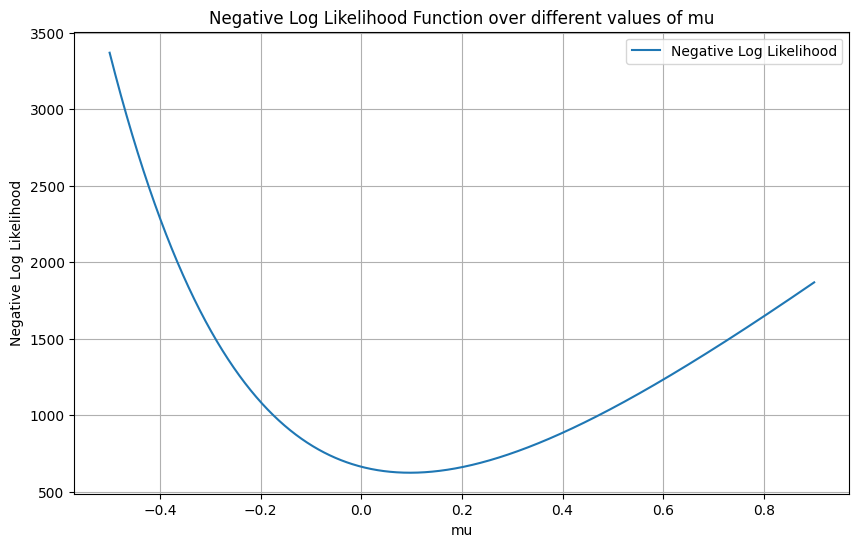

In [433]:
plot_likelihood(-0.5, 0.9, 1000, weibull_log_likelihood_belief, "mu", "weibull_belief", X, beta, y, alpha, 0, 15)

The mu value that minimizes the negative log likelihood is: -0.010204081632653073
Original value: 0


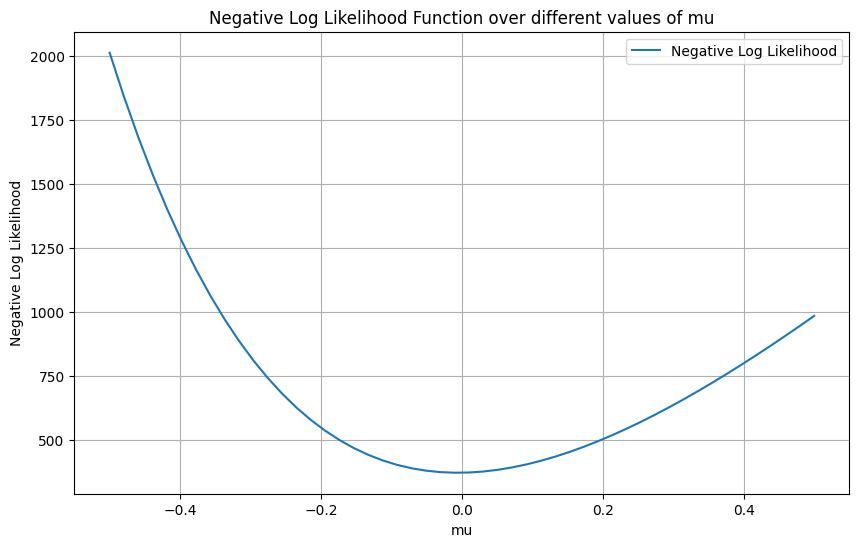

In [434]:
plot_likelihood(-0.5, 0.5, 50, weibull_log_likelihood, "mu", "weibull_lik", X, beta, y,  alpha, 0, 0)

The alpha value that minimizes the negative log likelihood is: 2.4000000000000004
Original value: 3.074546236251838


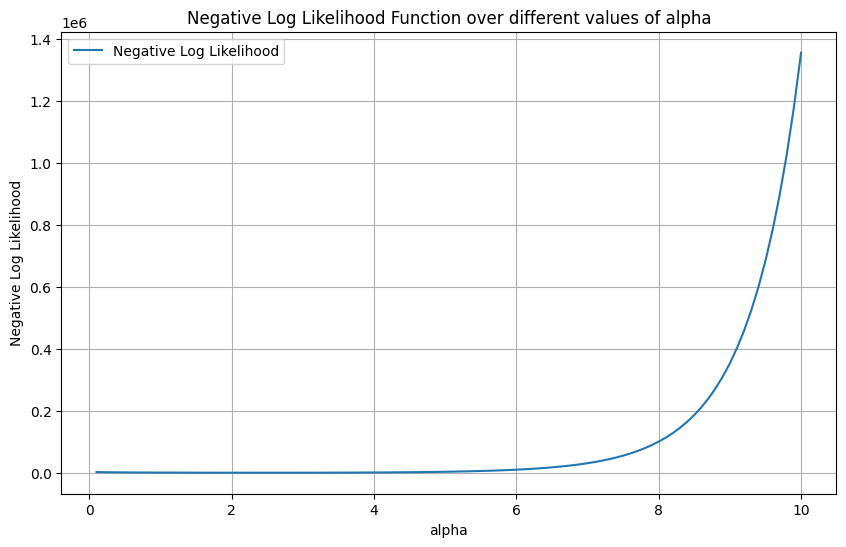

In [435]:
plot_likelihood(0.1, 10, 100, weibull_log_likelihood_belief, "alpha", "weibull_belief", X, beta, y,  alpha, 0, 15)

The alpha value that minimizes the negative log likelihood is: 3.1050505050505053
Original value: 3.074546236251838


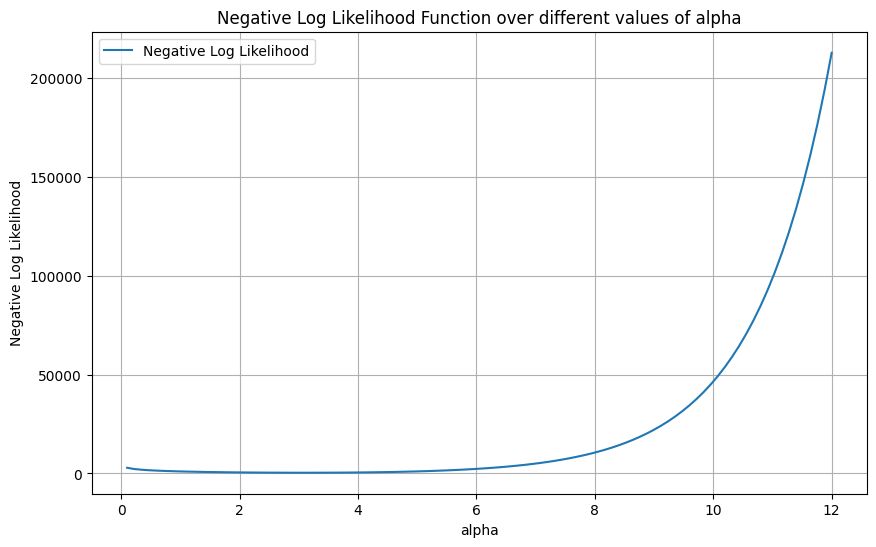

In [436]:
plot_likelihood(0.1, 12, 100, weibull_log_likelihood, "alpha", "weibull_lik", X, beta, y, alpha, 0, 15)

In [326]:
def integrand(z_i, y_i, hat_z_i, xi_k, alpha, mu, K):
    # Calculate the Gaussian probability density function
    gaussian_pdf = norm.pdf(z_i, loc=hat_z_i, scale=np.sqrt(1 / xi_k))
    
    # Calculate the log p(y_i | z_i, alpha, mu)
    log_p = alpha * (np.log(y_i) - mu - z_i) - K - np.exp(alpha * (np.log(y_i) - mu - z_i) - K) + np.log(alpha)
    
    # Return the product of the Gaussian PDF and log p
    return gaussian_pdf * log_p

def compute_integral_sum(y, hat_z, xi_k, alpha, mu, K):
    integral_sum = 0.0
    N = len(y)
    m_error = 0
    
    for i in range(N):
        y_i = y[i]
        hat_z_i = hat_z[i]
        
        # Perform the numerical integration for each term
        integral_value, error = quad(integrand, -100, 100, args=(y_i, hat_z_i, xi_k, alpha, mu, K))
        m_error = max(m_error, error)
        
        # Sum up the integrals
        integral_sum += integral_value
    
    return integral_sum, m_error

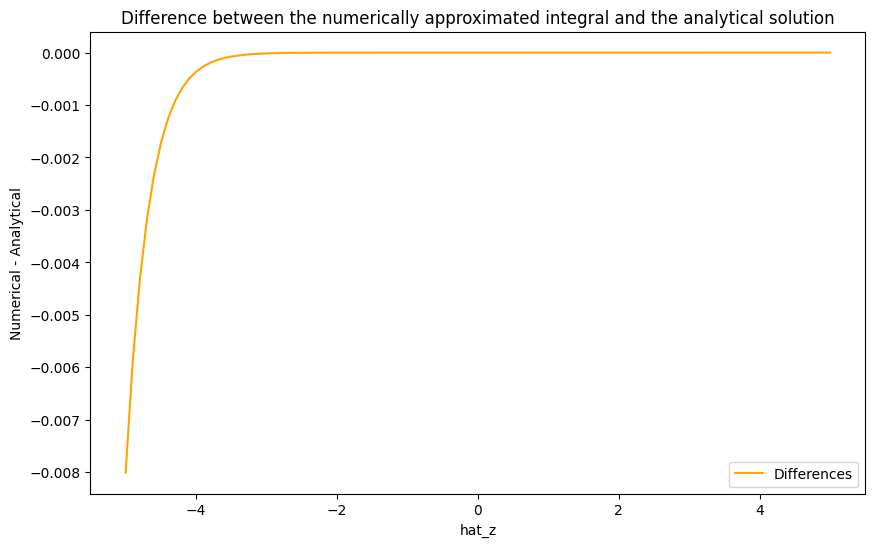

In [327]:
# Generating values for hat_z
hat_z_values = np.linspace(-5, 5, 100)
y = np.array([12.0])
xi_k = 1.2
alpha = 3.4
mu = 5.6
K = 7.8
emc = 0.9

# Computing results for each hat_z
integral_sum_results = [compute_integral_sum(y, np.array([hz]), xi_k, alpha, mu, emc)[0] for hz in hat_z_values]
weibull_likelihood_results = [weibull_log_likelihood_belief(torch.tensor([hz]), torch.tensor(y), torch.tensor(alpha), torch.tensor(mu), torch.tensor(xi_k), torch.tensor(emc)) for hz in hat_z_values]
weibull_likelihood_results = [w.item() for w in weibull_likelihood_results]
d = [integral_sum_results[i] - w for i, w in enumerate(weibull_likelihood_results)]
# Plotting the results on the same figure
plt.figure(figsize=(10, 6))

# Plot for weibull_likelihood
plt.plot(hat_z_values, d, label='Differences', color='orange')

# Adding labels and title
plt.xlabel('hat_z')
plt.ylabel('Numerical - Analytical')
plt.title('Difference between the numerically approximated integral and the analytical solution')
plt.legend()

plt.show()

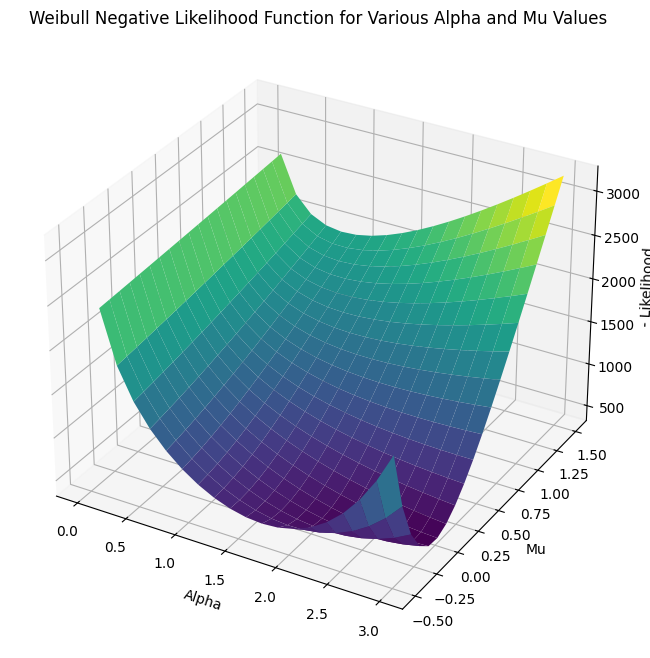

In [443]:
# Define the range of alpha and mu values
alpha_values = np.linspace(0, 3, 20)  # Example range for alpha
mu_values = np.linspace(-0.5, 1.5, 20)      # Example range for mu


# Calculate the likelihood for each pair of alpha and mu
likelihood_values = np.zeros((len(alpha_values), len(mu_values)))

for i, alpha in enumerate(alpha_values):
    for j, mu in enumerate(mu_values):
        # likelihood_values[i, j] = - weibull_likelihood_belief(
        #     torch.tensor(X@beta), 
        #     torch.tensor(y), 
        #     torch.tensor(alpha),
        #     torch.tensor(mu),
        #     torch.tensor(15),
        #     torch.tensor(emc),
        # )
        likelihood_values[i, j] = - weibull_log_likelihood(X, beta, y, mu, alpha)

# Create the meshgrid for alpha and mu
alpha_grid, mu_grid = np.meshgrid(alpha_values, mu_values)

# Plotting the 3D surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_grid, mu_grid, likelihood_values.T, cmap='viridis')

ax.set_xlabel('Alpha')
ax.set_ylabel('Mu')
ax.set_zlabel(' - Likelihood')
ax.set_title('Weibull Negative Likelihood Function for Various Alpha and Mu Values')

plt.show()